PICASO requires numpy>=1.22.4, but starry requires numpy<=1.21.6
Better to run this notebook in a new environment with PICASO installation
```
!which pip
%pip install virga-exo==0.3.4
%pip install picaso==3.1.2
```

In [1]:
import os
homedir = os.path.expanduser("~")
# Path to picaso reference data
ref = f"{homedir}/workspace/dopplerimg/venv/picaso/reference"
os.environ['picaso_refdata'] = ref
os.environ["PYSYN_CDBS"] = f"{ref}/grp/redcat/trds"
from picaso import justdoit as pj
from virga import justdoit as vj
from picaso import justplotit as picplt
import numpy as np
import pandas as pd
import astropy.units as u
from matplotlib import pyplot as plt

/Users/xqchen/anaconda3/envs/picasoenv/lib/python3.11/site-packages/picaso/justdoit.py:54: UserWarning: Your code version is 3.2.2 but your reference data version is 3.1. For some functionality you may experience Keyword errors. Please download the newest ref version or update your code: https://github.com/natashabatalha/picaso/tree/master/reference
  warnings.warn(f"Your code version is {__version__} but your reference data version is {ref_v}. For some functionality you may experience Keyword errors. Please download the newest ref version or update your code: https://github.com/natashabatalha/picaso/tree/master/reference")


MIRI

In [2]:
wave_range = [5.0, 15.0]
opafile = f"{homedir}/uoedrive/data/opacity/all_opacities_4.8_15_R20000.db"

opa = pj.opannection(wave_range=wave_range, filename_db=opafile)
#opa = pj.opannection(wave_range=wave_range)

In [3]:
# physcial properties
bd = pj.inputs(calculation='browndwarf')
Teff = 1300
bd.gravity(gravity=1000, gravity_unit=u.Unit('m/s**2'))
bd.phase_angle(0)
metallicity = 1 #atmospheric metallicity relative to Solar
mean_molecular_weight = 2.2 # atmospheric mean molecular weight

In [4]:
# prepare atmosphere pt and chemistry # OR 
ptfile = f"{homedir}/uoedrive/data/diamondback/tp_profiles/t{Teff}g1000nc_m0.0_co1.0.pt"
p_callie, t_callie = np.loadtxt(ptfile, usecols=[1,2], unpack=True, skiprows=2)
bd.add_pt(t_callie, p_callie)
bd.channon_grid_low(filename=os.path.join(os.environ.get('picaso_refdata'),'chemistry','visscher_abunds_m+0.0_co1.0' ))

In [5]:
def convert_unit(spectrum_output, R=1000):
    x, y = spectrum_output['wavenumber'], spectrum_output['thermal'] #units of erg/cm2/s/cm

    xmicron = 1e4/x

    flamy = y*1e-8 #per anstrom instead of per cm
    sp = pj.psyn.ArraySpectrum(xmicron, flamy,
                            waveunits='um',
                            fluxunits='FLAM')
    sp.convert("um")
    sp.convert('Fnu') #erg/cm2/s/Hz

    x = sp.wave #micron
    y = sp.flux #erg/cm2/s/Hz
    spectrum_output['wavelength'] = x
    spectrum_output['fluxnu'] = y
    x, y = pj.mean_regrid(x, y, R=R) # um, erg/cm2/s/Hz
    spectrum_output['regridy'] = y
    spectrum_output['regridx'] = x
    return x, y

In [6]:
# compute spectrum
cld_free = bd.spectrum(opa, full_output=True)
x_cld_free, y_cld_free = convert_unit(cld_free, R=3000)

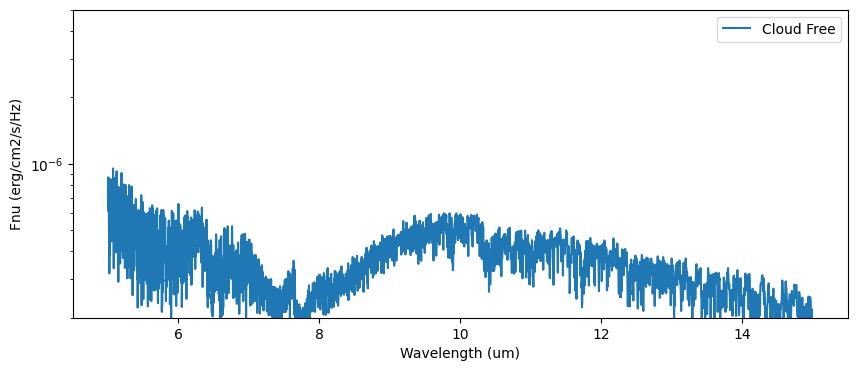

In [7]:
# show cld free spectrum
plt.figure(figsize=(10,4))
plt.plot(x_cld_free, y_cld_free, label='Cloud Free')
#plt.xlim(1, 5)
plt.ylim(2e-7, 0.5e-5)
plt.yscale('log')
plt.xlabel('Wavelength (um)')
plt.ylabel('Fnu (erg/cm2/s/Hz)')
plt.legend();

In [8]:
# compute cloudy spectrum
directory = f'{ref}/virga/'
# we can get the same full output from the virga run
cld_species = ['MgSiO3', 'Mg2SiO4', "Fe"]
fseds = [1, 2, 4, 8]
cld_out = {}
for fsed in fseds:
    bd = pj.inputs(calculation='browndwarf')
    Teff = 1300
    bd.gravity(gravity=1000, gravity_unit=u.Unit('m/s**2'))
    bd.phase_angle(0)
    # prepare atmosphere pt and chemistry
    ptfile = f"{homedir}/uoedrive/data/diamondback/tp_profiles/t{Teff}g1000f{fsed}_m0.0_co1.0.pt"
    p_callie, t_callie = np.loadtxt(ptfile, usecols=[1,2], unpack=True, skiprows=2)
    bd.add_pt(t_callie, p_callie)
    bd.channon_grid_low(filename=os.path.join(os.environ.get('picaso_refdata'),'chemistry','visscher_abunds_m+0.0_co1.0' ))
    bd.inputs['atmosphere']['profile']['kz'] = [1e9]*len(p_callie)
    bd.virga(cld_species, directory, fsed=fsed, mh=1, mmw=2.2)

    cldy = bd.spectrum(opa, full_output=True)
    x_cldy, y_cldy = convert_unit(cldy, R=3000)
    cld_out[f'fsed{fsed}'] = cldy

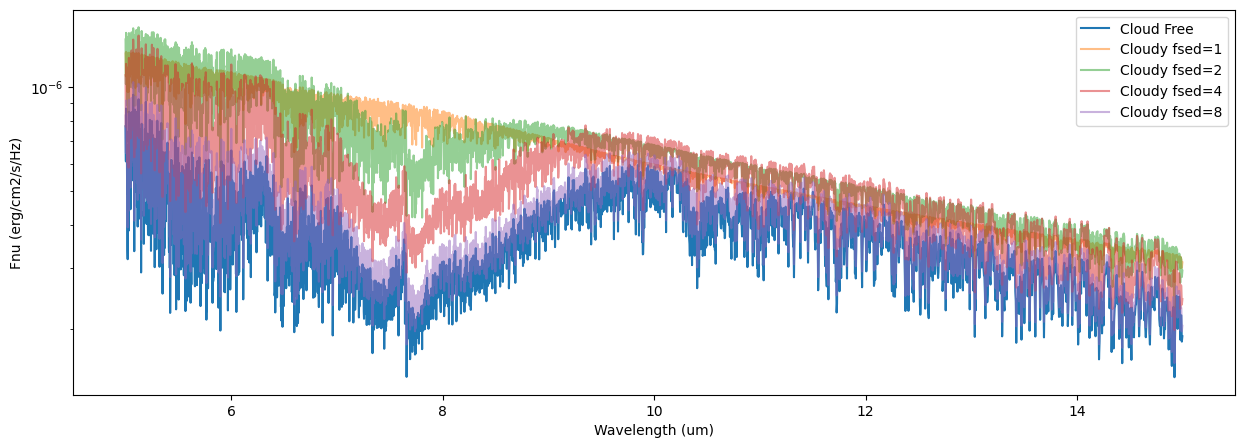

In [11]:
# show cldy spectrum
plt.figure(figsize=(15,5))
plt.plot(x_cld_free, y_cld_free, label='Cloud Free')
for fsed in fseds:
    plt.plot(cld_out[f'fsed{fsed}']['regridx'], cld_out[f'fsed{fsed}']['regridy'], 
             label=f'Cloudy fsed={fsed}', alpha=0.5)
#plt.xlim(1, 4.5)
#plt.ylim(0.5e-7, 0.5e-5)
plt.yscale('log')
plt.xlabel('Wavelength (um)')
plt.ylabel('Fnu (erg/cm2/s/Hz)')
plt.legend();

In [12]:
import matplotlib as mpl
def extend_colormap(cmap, end_color, factor=0.2, n=100):
    """ Extend a colormap to include a darker end color gradually.
    cmap: colormap instance, e.g., cm.OrRd
    end_color: the color to extend to, e.g., 'darkred'
    factor: proportion of the colormap to be replaced by the extended color
    n: number of colors in the new colormap
    """
    original_colors = cmap(np.linspace(0, 1, n))
    end_color_rgba = np.array(mpl.colors.to_rgba(end_color))
    
    extended_colors = []
    for i in range(n):
        if i < n * (1 - factor):
            extended_colors.append(original_colors[i])
        else:
            blend = (i - n * (1 - factor)) / (n * factor)
            blended_color = (1 - blend) * original_colors[i] + blend * end_color_rgba
            extended_colors.append(blended_color)
    
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list('extended_cmap', extended_colors)
    return new_cmap

def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=100):
    """ Truncate a colormap.
    cmap: colormap instance, e.g., cm.gist_heat
    min_val: the lower bound of the new colormap
    max_val: the upper bound of the new colormap
    n: number of colors in the new colormap
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({},{:.2f},{:.2f})'.format(cmap.name, min_val, max_val),
        cmap(np.linspace(min_val, max_val, n)))
    return new_cmap

In [9]:
cfmax = 5.28e13

In [13]:
# cldy CF plot
def plot_cf(df, R=45000):
    import matplotlib.ticker as ticker
    from scipy.ndimage import gaussian_filter
    from scipy.signal import savgol_filter
    #cmap = truncate_colormap(plt.cm.OrRd, 0.0, 1) #plt.cm.gist_heat_r #Blues #gist_heat_r #hot_r
    cmap = extend_colormap(plt.cm.OrRd, (0.2, 0.0, 0.0, 1), factor=0.2)
    cmap.set_under('white', alpha=0)
    fig, ax, CF = picplt.thermal_contribution(
        df['full_output'], norm=picplt.colors.LogNorm(vmin=1e8, vmax=1e11), tau_max=1, R=R, cmap=cmap)
        #df['full_output'], norm=picplt.colors.LogNorm(vmin=cfmax/1e3, vmax=cfmax), tau_max=1, R=R, cmap=cmap)

    y = []
    CF_scaled = np.empty_like(CF)
    for wav in np.arange(0, CF.shape[1], 1):
        y.append(p_callie[np.argmax(CF[:,wav])])
        CF_scaled[:, wav] = CF[:,wav]/np.nansum(CF[:,wav])
    x, _ = pj.mean_regrid(df['wavelength'], df['thermal'], R=R)
    y = np.array(y[::-1])
    #ax.plot(x, gaussian_filter(savgol_filter(y, 101, 1), 20), '--', color='white', linewidth=1.5)
    ax.plot(x, gaussian_filter(savgol_filter(y, 5, 1), 1), '--', color='white', linewidth=1.5)
    #ax.plot(x, gaussian_filter(savgol_filter(y, 51, 1), 10), '.', color='white', markersize=0.5)

    ax.set_ylim(0.5e2, 1e-2)
    #ax.set_xlim(1, 5)
    #ax.set_xscale('log')
    #ax.set_xticks(np.arange(1, 6), labels=[f'{i:.1f}' for i in np.arange(1, 6)])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_major_formatter('{x:.1f}')
    ax.xaxis.set_tick_params(labelsize=17)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    #ax.axvspan(1.51, 1.81, alpha=0.2, color='tab:blue', label="H")
    #ax.axvspan(1.95, 2.48, alpha=0.2, color='tab:blue', label="K")
    print(f'cfmax = {CF.max():.2e}')
    return CF, CF_scaled

In [14]:
sorted_labels_miri = np.array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.float32)
sorted_labels_miri.shape

(301,)

In [16]:
wls_miri = np.array([ 5.55178928,  5.61225653,  5.67129135,  5.72898579,  5.78543186,
        5.84072304,  5.89495182,  5.94820976,  6.00059128,  6.05217457,
        6.10299301,  6.15306616,  6.20241261,  6.25105286,  6.29900646,
        6.3462925 ,  6.39293098,  6.43894196,  6.48434401,  6.52915764,
        6.57340145,  6.61709642,  6.66026115,  6.70291567,  6.74507999,
        6.78677225,  6.82801342,  6.86882305,  6.90921974,  6.94922447,
        6.98885632,  7.02813435,  7.06707859,  7.10570621,  7.14402342,
        7.18203449,  7.21974325,  7.25715351,  7.29426908,  7.33109379,
        7.36763287,  7.4038887 ,  7.43986511,  7.47556782,  7.51099873,
        7.54616308,  7.58106422,  7.61570644,  7.65009356,  7.6842289 ,
        7.71811771,  7.75176239,  7.78516769,  7.81833839,  7.8512764 ,
        7.88398743,  7.91647434,  7.94874191,  7.980793  ,  8.01263237,
        8.04426384,  8.07569122,  8.10691929,  8.1379509 ,  8.16878891,
        8.19944   ,  8.22990608,  8.26019192,  8.29030132,  8.32023811,
        8.3500061 ,  8.37960911,  8.4090519 ,  8.43833733,  8.46747017,
        8.49645424,  8.5252924 ,  8.55398941,  8.58255005,  8.61097717,
        8.6392746 ,  8.66744614,  8.6954937 ,  8.72341728,  8.75121784,
        8.77889633,  8.8064518 ,  8.8338871 ,  8.86120319,  8.88839912,
        8.91547775,  8.94243813,  8.96928024,  8.99600792,  9.02261925,
        9.04911613,  9.07549953,  9.10176945,  9.12792683,  9.15397263,
        9.17990875,  9.20573425,  9.23145008,  9.25705719,  9.28255653,
        9.30795097,  9.33323669,  9.35841846,  9.38349533,  9.40846825,
        9.43333817,  9.45810509,  9.48277092,  9.50733566,  9.53180027,
        9.5561657 ,  9.58043289,  9.60460281,  9.62867546,  9.65265179,
        9.67653275,  9.70031929,  9.72401047,  9.74761009,  9.77111721,
        9.79453278,  9.81785679,  9.84109116,  9.86423683,  9.88729286,
        9.91026211,  9.93314457,  9.95594025,  9.97865105, 10.00127602,
       10.02381706, 10.04627609, 10.06865311, 10.0909481 , 10.11316109,
       10.13529587, 10.15735054, 10.17932701, 10.20122528, 10.2230463 ,
       10.24479103, 10.26646137, 10.28805542, 10.30957794, 10.33102608,
       10.35240173, 10.37370491, 10.39493847, 10.41610146, 10.43719578,
       10.45822144, 10.47917938, 10.50006866, 10.52089405, 10.54165268,
       10.56234741, 10.58297825, 10.60354519, 10.62405014, 10.6444931 ,
       10.66487598, 10.68519783, 10.7054615 , 10.72566605, 10.74581337,
       10.76590347, 10.78593636, 10.80591488, 10.82583809, 10.84570885,
       10.86552429, 10.88528824, 10.90500069, 10.92466259, 10.94427299,
       10.96383381, 10.98334408, 11.0028038 , 11.02221489, 11.04157448,
       11.06088638, 11.08014679, 11.09935951, 11.11852264, 11.13763809,
       11.15670395, 11.17572212, 11.1946907 , 11.21361256, 11.23248577,
       11.25131226, 11.2700901 , 11.28882122, 11.30750465, 11.32614231,
       11.34473228, 11.36327648, 11.38177395, 11.40022469, 11.4186306 ,
       11.43698978, 11.45530415, 11.47357273, 11.49179554, 11.50997353,
       11.52810669, 11.54619598, 11.5642395 , 11.5822401 , 11.60019588,
       11.6181078 , 11.63597584, 11.65380001, 11.67158127, 11.68931961,
       11.70701408, 11.7246666 , 11.74227619, 11.75984383, 11.77736855,
       11.7948513 , 11.8122921 , 11.82969093, 11.84704876, 11.86436558,
       11.88164043, 11.89887524, 11.91606903, 11.93322182, 11.95033455,
       11.96740723, 11.98443985, 12.00143242, 12.01838493, 12.0352993 ,
       12.05217361, 12.06900883, 12.08580494, 12.1025629 , 12.11928177,
       12.13596249, 12.15260601, 12.16921043, 12.18577766, 12.20230675,
       12.21879959, 12.23525429, 12.25167084, 12.26805305, 12.28439713,
       12.30070496, 12.31697655, 12.3332119 , 12.34941196, 12.36557579,
       12.38170433, 12.39779758, 12.41385555, 12.42987823, 12.44586658,
       12.4618206 , 12.47773933, 12.49362373, 12.50947571, 12.52529335,
       12.54107666, 12.55682564, 12.57254314, 12.58822632, 12.60387802,
       12.61949539, 12.63508129, 12.65063381, 12.66615486, 12.68164444,
       12.69710159, 12.71252728, 12.72792149, 12.74328423, 12.75861549,
       12.77391815, 12.78918839, 12.8044281 , 12.8196373 , 12.83481789,
       12.849967  , 12.86508751, 12.8801775 , 12.89523888, 12.91027069,
       12.92527294, 12.94024754, 12.95519257, 12.97010994, 12.9849987 ,
       12.99985886], dtype=np.float32)
wls_miri.shape

(301,)

cfmax = 2.09e+10


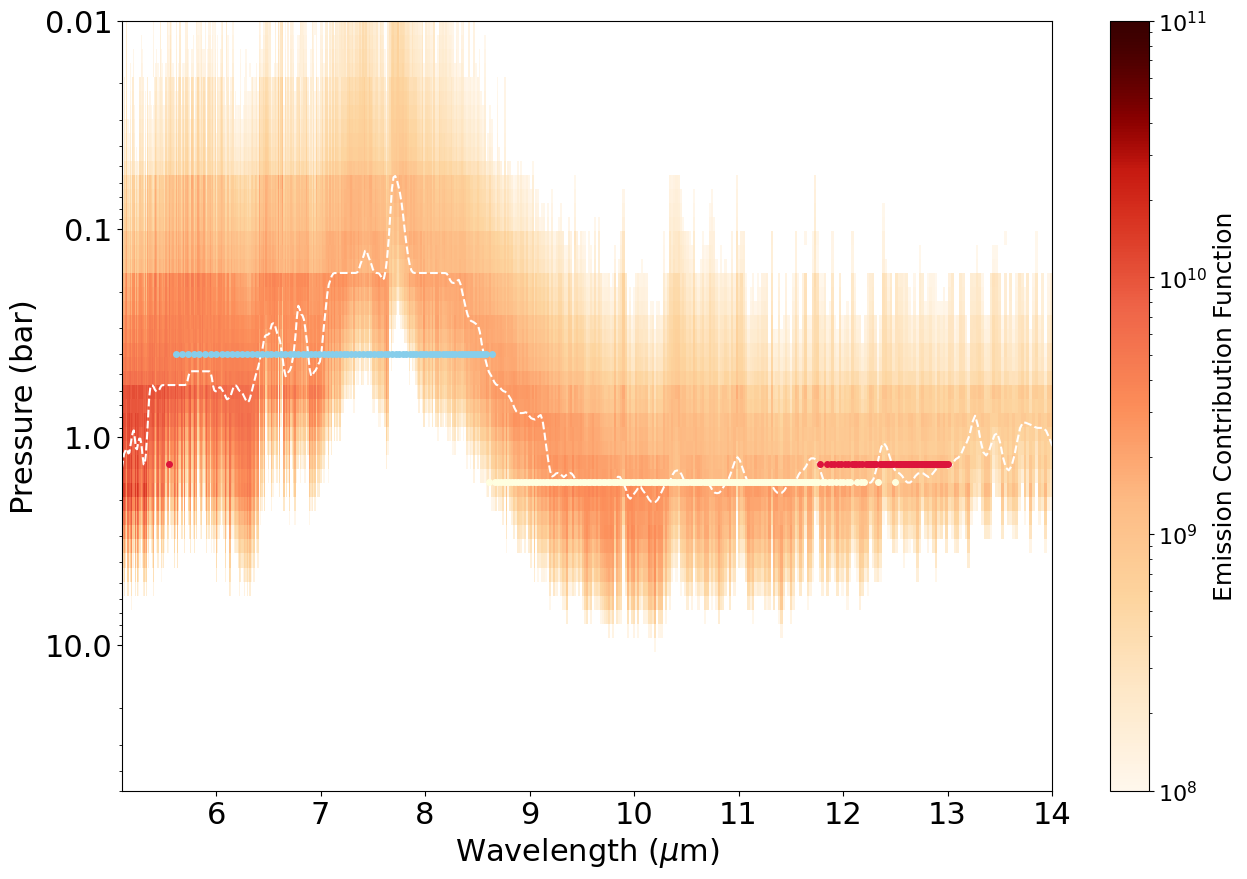

In [35]:
ap=1
cf, cf_scaled = plot_cf(cld_free, R=500)
clusters = sorted_labels_miri
wls = wls_miri
ms=8
#plt.text(1.6, 3., "H", color="white", fontsize=20)
#plt.text(2.15, 2., "K", color="white", fontsize=20)
#plt.text(1.71, 42, "H", color="darkslategrey", fontsize=20)
#plt.text(2.36, 42, "K", color="darkslategrey", fontsize=20)
#plt.plot(wls, clusters+1., '.', color='b')
#plt.title(f"Cloudless, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20})
plt.xscale('linear')
plt.xlim(5.1, 14)
ind0 = np.where(clusters==2)[0]
ind1 = np.where(clusters==1)[0]
ind2 = np.where(clusters==0)[0]
plt.plot(wls[ind0], 0.4*np.ones_like(wls[ind0]), '.', color='skyblue', ms=ms, alpha=ap)
plt.plot(wls[ind1], 1.65*np.ones_like(wls[ind1]), '.', color='lightyellow', ms=ms, alpha=ap)
plt.plot(wls[ind2], 1.35*np.ones_like(wls[ind2]), '.', color='crimson', ms=ms, alpha=ap)
#plt.plot(wls[ind2], clusters[ind2]+1., '.', color='magenta')
plt.xticks([6,7,8,9,10,11,12,13,14],fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Wavelength ($\mu$m)", fontsize=22)
plt.ylabel("Pressure (bar)", fontsize=22)
plt.savefig('cf_miri.png', dpi=200, bbox_inches='tight', transparent=True);

NIRSpec

In [25]:
wls = np.array(wls)
clusters = np.array(clusters)

cfmax = 5.28e+13


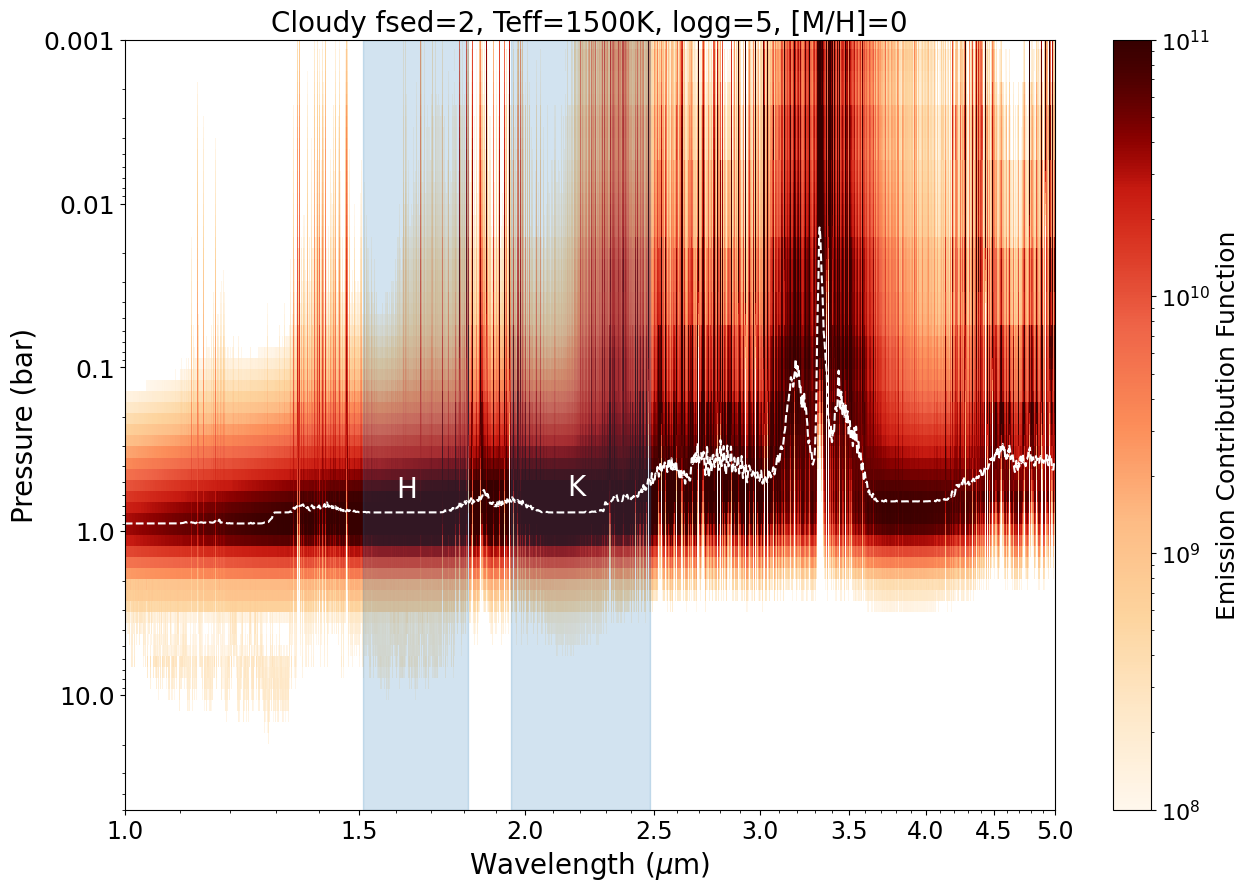

In [8]:
cf_cldy, cf_cldy_scaled = plot_cf(cld_out['fsed2'])
plt.text(1.6, 0.62, "H", color="white", fontsize=20)
plt.text(2.15, 0.6, "K", color="white", fontsize=20)
plt.title(f"Cloudy fsed=2, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20})
plt.savefig('cf_cldy_fsed2.png', dpi=200, bbox_inches='tight', transparent=True);

cfmax = 5.28e+13


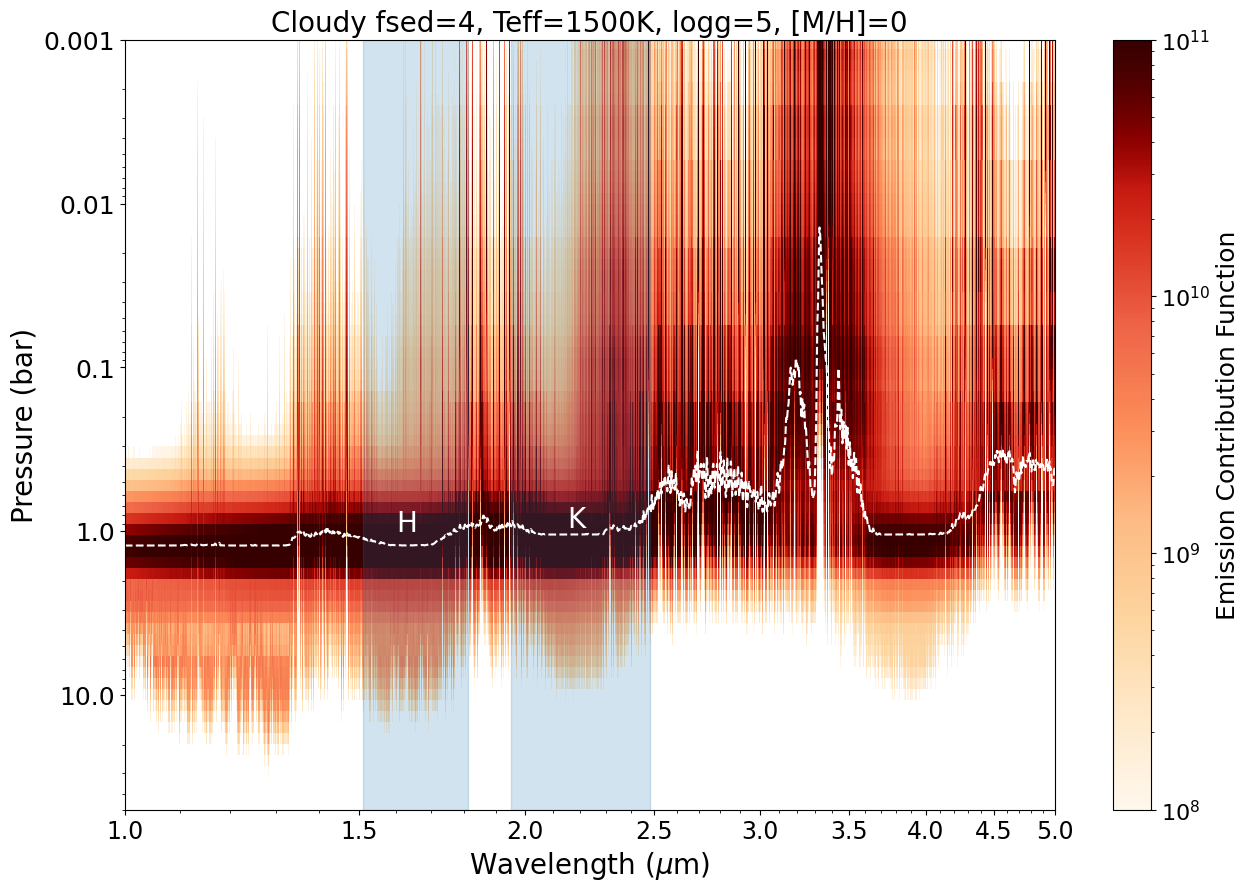

In [25]:
cf_cldy, cf_cldy_scaled = plot_cf(cld_out['fsed4'])
plt.text(1.6, 1., "H", color="white", fontsize=20)
plt.text(2.15, 0.95, "K", color="white", fontsize=20)
plt.title(f"Cloudy fsed=4, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20});

cfmax = 5.28e+13


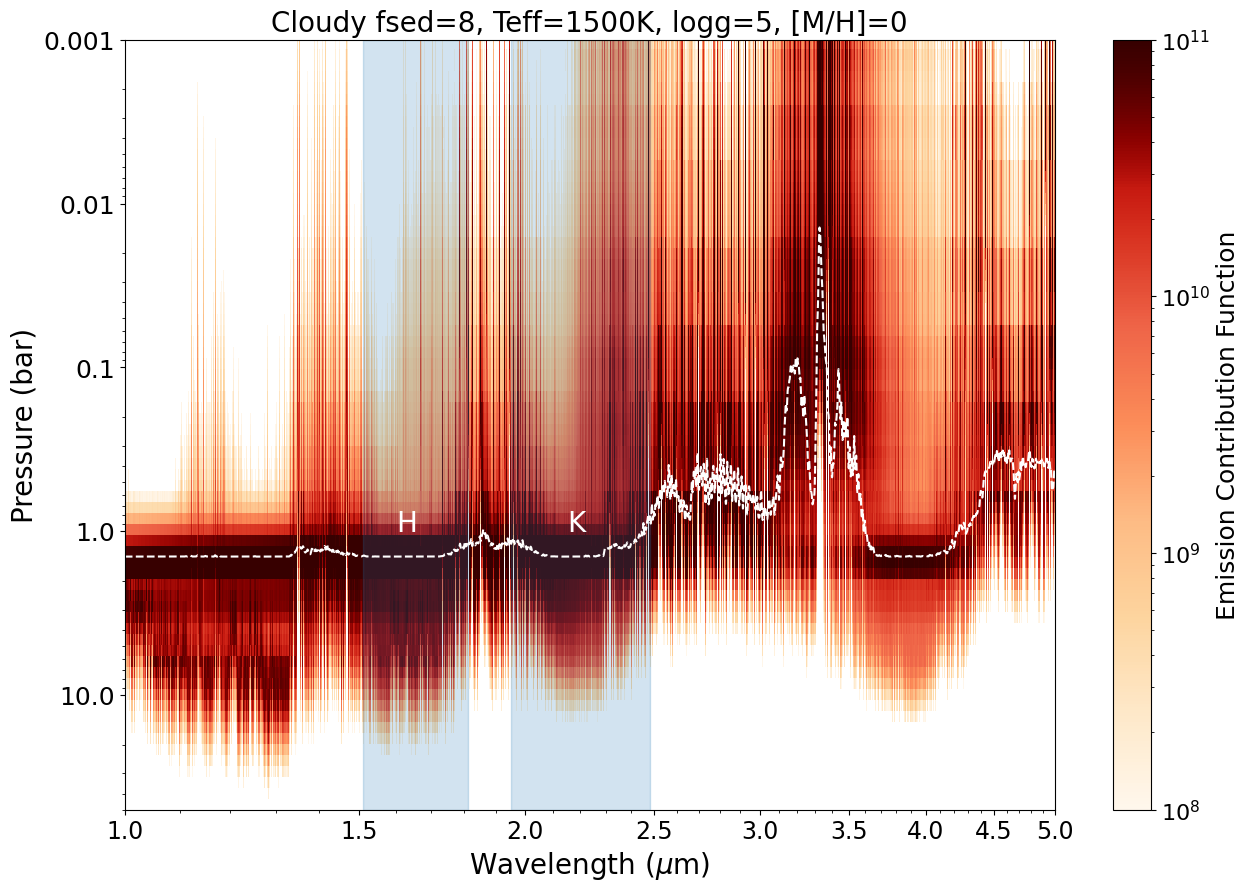

In [26]:
cf_cldy, cf_cldy_scaled = plot_cf(cld_out['fsed8'])
plt.text(1.6, 1, "H", color="white", fontsize=20)
plt.text(2.15, 1, "K", color="white", fontsize=20)
plt.title(f"Cloudy fsed=8, Teff={Teff}K, logg=5, [M/H]=0", fontdict={'fontsize': 20});

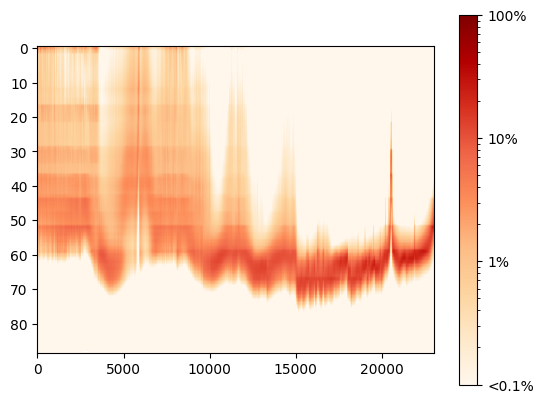

In [58]:
plt.imshow(cf_scaled, aspect=200, norm=picplt.colors.LogNorm(vmin=1e-3, vmax=1), cmap=plt.cm.OrRd)
cbar = plt.colorbar()
cbar.set_ticks([1e-3, 1e-2, 1e-1, 1])
cbar.set_ticklabels(['<0.1%', '1%', '10%', '100%'])

In [28]:
# show condensates
from bokeh.io import output_notebook
output_notebook()
recommended = vj.recommend_gas(p_callie, t_callie, metallicity, mean_molecular_weight, plot=True, height=400, width=600,)

Loading BokehJS ...

In [10]:
!pip freeze

aesara-theano-fallback==0.1.0
alabaster==0.7.16
appnope==0.1.4
arviz==0.12.1
astropy==5.3.4
asttokens==2.4.1
Babel==2.15.0
beautifulsoup4==4.12.3
bibtexparser==1.4.1
bleach==6.1.0
bokeh==2.4.3
cachetools==5.3.3
Cartopy==0.22.0
certifi==2024.7.4
cftime==1.6.4
charset-normalizer==3.3.2
colorcet==3.1.0
comm==0.2.2
contourpy==1.2.1
corner==2.2.2
cycler==0.12.1
debugpy==1.8.2
decorator==5.1.1
deprecat==2.1.1
dill==0.3.8
docutils==0.21.2
dynesty==2.1.4
emcee==3.1.0
exceptiongroup==1.2.1
executing==2.0.1
exoplanet==0.5.3
exoplanet_core==0.1.2
fastprogress==1.0.3
filelock==3.15.4
fonttools==4.53.1
h5netcdf==1.3.0
h5py==3.11.0
holoviews==1.17.1
idna==3.7
imagesize==1.4.1
importlib_metadata==8.0.0
importlib_resources==6.4.0
ipykernel==6.29.5
ipython==8.18.1
jedi==0.19.1
Jinja2==3.1.2
joblib==1.4.2
jupyter_client==8.6.2
jupyter_core==5.7.2
kiwisolver==1.4.5
llvmlite==0.43.0
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.7.2
matplotlib-inline==0.1.7
nest-asyncio==1.6.0
netCDF4==1.6.0
numba==0.60.0
